# Question-1

In [8]:
import pandas as pd
from math import sqrt
from scipy.stats import norm

In [ ]:
test = pd.read_csv(r"E:\DSC-431-MATH\HW5\test_results.csv")
users = pd.read_csv(r"E:\DSC-431-MATH\HW5\user_table.csv")

df = test.merge(users, on="user_id", how="left")
df.head()


,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


In [2]:
df.rename(columns={'price': 'price_raw'}, inplace=True)


In [3]:
df['price'] = df['test'].map({0: 39, 1: 59})

In [4]:
df.groupby('test')['price'].unique()


test
0    [39]
1    [59]
Name: price, dtype: object

In [5]:
df.isna().sum()


Unnamed: 0              0
user_id                 0
timestamp             334
source                312
device                  0
operative_system    20339
test                    0
price_raw               0
converted               0
city                41184
country             41184
lat                 41184
long                41184
price                   0
dtype: int64

In [12]:
summary = df.groupby('test').agg(
    users=('user_id', 'count'),
    conversions=('converted', 'sum'),
    price=('price', 'mean')
).reset_index()

summary['conversion_rate'] = summary['conversions'] / summary['users']
summary['revenue_per_user'] = summary['conversion_rate'] * summary['price']
summary['group'] = summary['test'].map({0: 'control_39', 1: 'test_59'})

summary[['group', 'users', 'conversions', 'conversion_rate',
         'price', 'revenue_per_user']]


,group,users,conversions,conversion_rate,price,revenue_per_user
0,control_39,202727,4035,0.019904,39.0,0.776241
1,test_59,114073,1773,0.015543,59.0,0.917018


In [13]:
# extract counts
row_control = summary[summary['test'] == 0].iloc[0]
row_test    = summary[summary['test'] == 1].iloc[0]

conv_control  = row_control['conversions']
users_control = row_control['users']

conv_test  = row_test['conversions']
users_test = row_test['users']

# conversion rates
p1 = conv_control / users_control
p2 = conv_test / users_test

# pooled proportion
p_pool = (conv_control + conv_test) / (users_control + users_test)

# z-statistic
z = (p1 - p2) / sqrt(p_pool * (1 - p_pool) * (1/users_control + 1/users_test))

# two-sided p-value
p_value = 2 * norm.sf(abs(z))

print(f"Control ($39) conversion: {p1:.4%}")
print(f"Test    ($59) conversion: {p2:.4%}")
print(f"Z-statistic: {z:.3f}")
print(f"p-value    : {p_value:.4f}")

Control ($39) conversion: 1.9904%
Test    ($59) conversion: 1.5543%
Z-statistic: 8.783
p-value    : 0.0000


As p value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in conversion rates between the $39 and $59 price points.

We get Revenue per user by multiplying conversion with price. So for 39$ it is  0.78(39*1.99) and for 59$ it is 0.92(59*1.55)

### Q1. Should the company continue selling at $39 or raise the price to $59?

The experiment compared two groups of users:

| Group | Price | Conversion Rate | Revenue per User |
|:------|:------|:----------------|:----------------|
| Control | $39 | **1.99 %** | **\$0.78** |
| Test | $59 | **1.55 %** | **\$0.92** |

A two-proportion z-test confirmed that the drop in conversion rate at $59 is **statistically significant**  
(*z = 8.78, p ≈ 0.0000*), meaning users truly convert less often when shown the higher price.

However, the higher price more than compensates for this reduction,average revenue per visitor rises by roughly **18 %** at $59.

**Conclusion:**  
Despite fewer conversions, the $59 variant yields greater revenue per visitor. The company should therefore **adopt the $59 price** as the new standard while continuing to monitor long-term effects on customer retention and satisfaction.


# Question-2

In [15]:
def segment_analysis(df, segment_col):
    seg = (df
           .groupby([segment_col, 'test'])
           .agg(
               users=('user_id', 'count'),
               conversions=('converted', 'sum'),
               price=('price', 'mean')
           )
           .reset_index())
    
    seg['conversion_rate'] = seg['conversions'] / seg['users']
    seg['revenue_per_user'] = seg['conversion_rate'] * seg['price']
    
    # add nicer labels for test
    seg['group'] = seg['test'].map({0: 'control_39', 1: 'test_59'})
    return seg

In [16]:
seg_device = segment_analysis(df, 'device')
seg_device

,device,test,users,conversions,price,conversion_rate,revenue_per_user,group
0,mobile,0,120481,2395,39.0,0.019879,0.775267,control_39
1,mobile,1,65990,1065,59.0,0.016139,0.952190,test_59
2,web,0,82246,1640,39.0,0.019940,0.777667,control_39
3,web,1,48083,708,59.0,0.014725,0.868748,test_59


In [17]:
seg_device_pivot = seg_device.pivot_table(
    index='device',
    columns='group',
    values=['conversion_rate', 'revenue_per_user']
)

seg_device_pivot


conversion_rate           revenue_per_user          
group       control_39   test_59       control_39   test_59
device                                                     
mobile        0.019879  0.016139         0.775267  0.952190
web           0.019940  0.014725         0.777667  0.868748

In [18]:
seg_source = segment_analysis(df, 'source')

# See the biggest traffic sources first
seg_source.sort_values('users', ascending=False).head(15)


,source,test,users,conversions,price,conversion_rate,revenue_per_user,group
10,direct_traffic,0,38727,525,39.0,0.013556,0.528701,control_39
2,ads-google,0,37833,854,39.0,0.022573,0.880343,control_39
6,ads_facebook,0,34066,807,39.0,0.023689,0.923883,control_39
11,direct_traffic,1,21580,218,59.0,0.010102,0.596015,test_59
3,ads-google,1,21486,422,59.0,0.019641,1.158801,test_59
7,ads_facebook,1,19271,325,59.0,0.016865,0.995018,test_59
8,ads_other,0,19266,297,39.0,0.015416,0.601215,control_39
16,seo-google,0,15092,265,39.0,0.017559,0.684800,control_39
0,ads-bing,0,14595,195,39.0,0.013361,0.521069,control_39
22,seo_facebook,0,13458,235,39.0,0.017462,0.681008,control_39


In [19]:
seg_source_pivot = seg_source.pivot_table(
    index='source',
    columns='group',
    values=['conversion_rate', 'revenue_per_user']
)

seg_source_pivot


conversion_rate           revenue_per_user          
group                control_39   test_59       control_39   test_59
source                                                              
ads-bing               0.013361  0.009569         0.521069  0.564559
ads-google             0.022573  0.019641         0.880343  1.158801
ads-yahoo              0.016833  0.011228         0.656484  0.662441
ads_facebook           0.023689  0.016865         0.923883  0.995018
ads_other              0.015416  0.012473         0.601215  0.735897
direct_traffic         0.013556  0.010102         0.528701  0.596015
friend_referral        0.041768  0.033369         1.628963  1.968750
seo-bing               0.030053  0.013447         1.172051  0.793399
seo-google             0.017559  0.015989         0.684800  0.943356
seo-other              0.017502  0.012481         0.682583  0.736404
seo-yahoo              0.019536  0.010463         0.761894  0.617304
seo_facebook           0.017462  0.013589         0.681008  0.801734

In [20]:
seg_os = segment_analysis(df, 'operative_system')
seg_os.sort_values('users', ascending=False)


,operative_system,test,users,conversions,price,conversion_rate,revenue_per_user,group
12,windows,0,63532,1188,39.0,0.018699,0.729270,control_39
8,iOS,0,61789,1459,39.0,0.023613,0.920892,control_39
0,android,0,48157,788,39.0,0.016363,0.638163,control_39
13,windows,1,37346,523,59.0,0.014004,0.826246,test_59
9,iOS,1,33563,671,59.0,0.019992,1.179543,test_59
1,android,1,26699,330,59.0,0.012360,0.729241,test_59
10,mac,0,16348,417,39.0,0.025508,0.994801,control_39
11,mac,1,8708,185,59.0,0.021245,1.253445,test_59
6,i0S,0,66,0,39.0,0.000000,0.000000,control_39
14,wnddows,0,59,1,39.0,0.016949,0.661017,control_39


In [21]:
country_counts = (
    df.groupby('country')
      .agg(users=('user_id', 'count'))
      .reset_index()
      .sort_values('users', ascending=False)
)

top_countries = country_counts.head(10)['country']

seg_country = segment_analysis(df[df['country'].isin(top_countries)], 'country')
seg_country


,country,test,users,conversions,price,conversion_rate,revenue_per_user,group
0,USA,0,176428,3489,39.0,0.019776,0.771255,control_39
1,USA,1,99188,1530,59.0,0.015425,0.910090,test_59


In [22]:
seg_country_pivot = seg_country.pivot_table(
    index='country',
    columns='group',
    values=['conversion_rate', 'revenue_per_user']
)

seg_country_pivot


conversion_rate           revenue_per_user         
group        control_39   test_59       control_39  test_59
country                                                    
USA            0.019776  0.015425         0.771255  0.91009

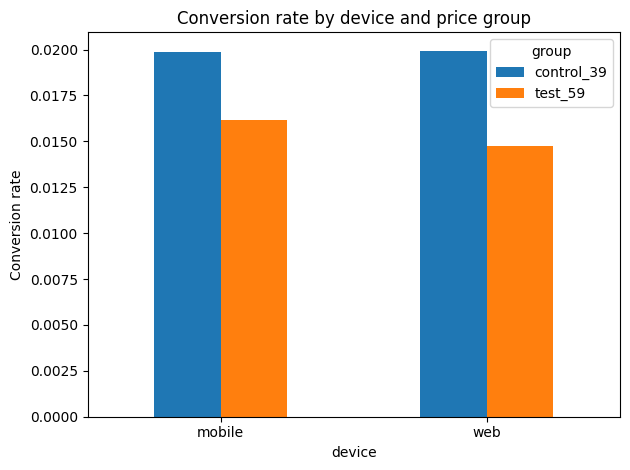

In [23]:
import matplotlib.pyplot as plt

seg_device_plot = seg_device.pivot_table(
    index='device',
    columns='group',
    values='conversion_rate'
)

seg_device_plot.plot(kind='bar')
plt.ylabel("Conversion rate")
plt.title("Conversion rate by device and price group")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Q2. Key findings from user behaviour and opportunities to increase conversion

To understand how different users reacted to the price change and how we can still increase conversion, I analysed conversion and revenue per user by **device**, **traffic source**, **operating system**, and **country**.

Overall, the $59 price lowers conversion but raises revenue per visitor. The segment analysis shows where this tradeoff is strong, and where it is weak.

---

#### 1. Device-level behaviour

From the device table:

| Device | Price group | Users   | Conversion rate | Revenue per user |
|--------|-------------|---------|-----------------|------------------|
| Mobile | $39 (control) | 120,481 | **1.99%** | **\$0.78** |
| Mobile | $59 (test)    | 65,990  | **1.61%** | **\$0.95** |
| Web    | $39 (control) | 82,246  | **1.99%** | **\$0.78** |
| Web    | $59 (test)    | 48,083  | **1.47%** | **\$0.87** |

**Observations**

- Conversion falls on both devices when price increases from \$39 to \$59:
  - Mobile: 1.99% → 1.61%
  - Web: 1.99% → 1.47%
- Despite this, **revenue per user increases on both**:
  - Mobile: \$0.78 → \$0.95 (≈ 22% uplift)
  - Web: \$0.78 → \$0.87 (≈ 12% uplift)
- The uplift is **stronger on mobile**, suggesting mobile users are slightly less price-sensitive.

**Actionable insights (device)**

- Keep the \$59 price on both devices: it clearly increases revenue per visitor.
- Focus **web UX and messaging improvements** to recover some of the extra conversion loss there:
  - simplify checkout on desktop,
  - emphasise value/benefits more clearly on web landing pages,
  - test guarantees or free-trial messaging targeted at web visitors.

---

#### 2. Traffic source (marketing channel)

From the source pivot (showing selected high-traffic channels):

| Source         | Conv. rate @ \$39 | Conv. rate @ \$59 | RPU @ \$39 | RPU @ \$59 |
|----------------|-------------------|-------------------|-----------|-----------|
| ads-google     | 2.26%             | 1.96%             | \$0.88    | **\$1.16** |
| ads-facebook   | 2.37%             | 1.69%             | \$0.92    | **\$1.00** |
| ads-bing       | 1.34%             | 0.96%             | \$0.52    | **\$0.56** |
| ads-other      | 1.54%             | 1.25%             | \$0.60    | **\$0.74** |
| direct_traffic | 1.36%             | 1.01%             | \$0.53    | **\$0.60** |
| friend_referral| 4.18%             | 3.34%             | \$1.63    | **\$1.97** |
| seo-google     | 1.76%             | 1.60%             | \$0.68    | **\$0.94** |
| seo-other      | 1.75%             | 1.25%             | \$0.68    | **\$0.74** |
| seo-facebook   | 1.75%             | 1.36%             | \$0.68    | **\$0.80** |
| seo-bing       | 3.01%             | 1.34%             | **\$1.17**| \$0.79    |
| seo-yahoo      | 1.95%             | 1.05%             | **\$0.76**| \$0.62    |

**Observations**

- For **most paid and organic channels**, the \$59 price **increases revenue per user**, even though conversion drops:
  - ads-google, ads-facebook, ads-bing, ads-other, direct_traffic, friend_referral, seo-google, seo-other, and seo-facebook all have higher RPU at \$59.
- **Friend_referral** stands out:
  - Very high conversion (4.18% → 3.34%),
  - Highest revenue per user (\$1.63 → \$1.97).
- Two notable exceptions:
  - **seo-bing:** RPU falls from \$1.17 to \$0.79 at \$59.
  - **seo-yahoo:** RPU falls from \$0.76 to \$0.62 at \$59.

**Actionable insights (source)**

- **Double down on strong sources:**
  - Scale **friend_referral** (referral programmes, “invite a friend” incentives) – this is the star channel.
  - Maintain and optimise **google ads** and **facebook ads**, where RPU at \$59 is clearly higher.
- **Fix underperforming but important sources:**
  - Channels like **direct_traffic** and some organic SEO sources have modest conversion; improving landing pages and messaging for these visitors could raise conversion without changing price.
- **Consider tailored treatment for weak segments:**
  - For **seo-bing** and **seo-yahoo**, the higher price actually *reduces* revenue per user. These might be good candidates for:
    - targeted discounts,
    - country/engine-specific promotions,
    - or leaving some users at a lower effective price while keeping \$59 as the list price.

---

#### 3. Operating system

From the OS table (major platforms):

| OS       | Price | Users  | Conv. rate | RPU      |
|----------|-------|--------|-----------|----------|
| Windows  | \$39  | 63,532 | 1.87%     | \$0.73   |
| Windows  | \$59  | 37,346 | 1.40%     | **\$0.83** |
| Android  | \$39  | 48,157 | 1.64%     | \$0.64   |
| Android  | \$59  | 26,699 | 1.24%     | **\$0.73** |
| iOS      | \$39  | 61,789 | 2.36%     | \$0.92   |
| iOS      | \$59  | 33,563 | 2.00%     | **\$1.18** |
| Mac      | \$39  | 16,348 | 2.55%     | \$0.99   |
| Mac      | \$59  | 8,708  | 2.12%     | **\$1.25** |

**Observations**

- **Apple users (iOS and Mac)** have the **highest conversion rates** and the **highest revenue per user** at both prices.
  - iOS RPU: \$0.92 → \$1.18  
  - Mac RPU: \$0.99 → \$1.25
- Windows and Android users show lower conversion, but RPU still increases at \$59:
  - Windows: \$0.73 → \$0.83  
  - Android: \$0.64 → \$0.73

**Actionable insights (OS)**

- The **Apple ecosystem is both high-conversion and high-value**. These users tolerate the higher price well:
  - target them with premium/polished messaging,
  - prioritise high-quality iOS/Mac UX.
- For **Windows and Android**, where conversion is lower:
  - focus on onboarding, performance, and clearer value explanation to help hesitant users justify the \$59 price.
  - ensure the site performs well on low- to mid-range devices (especially Android).

---

#### 4. Geography

For the top country by volume (USA):

| Country | Price | Users   | Conv. rate | RPU      |
|---------|-------|---------|-----------|----------|
| USA     | \$39  | 176,428 | 1.98%     | \$0.77   |
| USA     | \$59  | 99,188  | 1.54%     | **\$0.91** |

**Observations**

- In the USA, conversion drops from 1.98% to 1.54% at \$59, but **revenue per user rises** from \$0.77 to \$0.91 (≈ 18% uplift), very similar to the global pattern.

**Actionable insight (geography)**

- At least for the largest market (USA), \$59 is clearly sustainable and more profitable.
- If other countries were added, we could look for markets where RPU does *not* improve at \$59 and consider regional pricing or local discounts there.

---

#### 5. Overall behavioural takeaways

- The price increase from **\$39 → \$59**:
  - **reduces conversion** across all segments,
  - but **increases revenue per visitor** for almost every major segment (devices, most sources, main OSs, and USA).
- Strong segments where the higher price works very well:
  - **Mobile users**,  
  - **Friend referrals**,  
  - **Google/Facebook ads**,  
  - **iOS and Mac users**,  
  - **USA**.
- A few segments (notably **seo-bing** and **seo-yahoo**) actually see **lower revenue per user** at \$59.

**Actionable recommendations**

1. **Keep the \$59 price overall**, as it meaningfully increases revenue per visitor.
2. **Optimise weak parts of the funnel** instead of lowering price:
   - Improve web and Windows/Android UX and messaging, where conversion drops most.
   - Tune landing pages and ad copy for underperforming but high-volume channels.
3. **Lean into strong segments**:
   - Expand referral programmes and marketing on high-performing channels and platforms (referrals, google ads, iOS/Mac).
4. **Experiment with targeted offers** for the few segments where RPU falls at \$59 (e.g. certain SEO sources), instead of changing the global list price.

Overall, the test shows that users *do* react to the higher price, but the extra revenue per sale more than compensates, especially in high-intent and high-value segments.


# Question-3

In [24]:

p1 = 0.019904   # control conv
p2 = 0.015543   # test conv

p_bar = (p1 + p2) / 2
delta = abs(p1 - p2)

z_alpha = 1.96   # 5% sig, two-sided
z_beta  = 0.84   # 80% power

n_per_group = 2 * p_bar * (1 - p_bar) * (z_alpha + z_beta)**2 / (delta**2)
print("Required users per group (approx):", n_per_group)


Required users per group (approx): 14353.477362629417


In [25]:
summary[['group', 'users']]


,group,users
0,control_39,202727
1,test_59,114073


In [26]:
df_time = df.copy()
df_time['timestamp'] = pd.to_datetime(df_time['timestamp'], errors='coerce')

# drop rows with missing timestamp for this analysis
df_time = df_time.dropna(subset=['timestamp'])

df_time['date'] = df_time['timestamp'].dt.date


In [27]:
daily = (df_time
         .groupby(['date', 'test'])
         .agg(users=('user_id', 'count'),
              conversions=('converted', 'sum'))
         .reset_index())

# pivot to have separate columns for control/test
daily_pivot = daily.pivot(index='date', columns='test', values='users').fillna(0)
daily_pivot.columns = ['users_control', 'users_test']  # assuming column order [0,1]
daily_pivot = daily_pivot.sort_index()

# cumulative users over time
daily_pivot['cum_users_control'] = daily_pivot['users_control'].cumsum()
daily_pivot['cum_users_test']    = daily_pivot['users_test'].cumsum()

daily_pivot.head()


,users_control,users_test,cum_users_control,cum_users_test
date,,,,
2015-03-02,998,569,998,569
2015-03-03,902,574,1900,1143
2015-03-04,942,453,2842,1596
2015-03-05,1743,1033,4585,2629
2015-03-06,4533,2567,9118,5196


In [ ]:
required = 14354 # approximated to nearest integer for eassier use

stopping_candidates = daily_pivot[
    (daily_pivot['cum_users_control'] >= required) &
    (daily_pivot['cum_users_test']    >= required)
]

stopping_candidates.head(1)


,users_control,users_test,cum_users_control,cum_users_test
date,,,,
2015-03-14,3669,2001,28395,15707


In [32]:
start_date = daily_pivot.index.min()
stop_date  = stopping_candidates.index[0]

days_run = (stop_date - start_date).days + 1
print("Test start date:", start_date)
print("Earliest reasonable stopping date:", stop_date)
print("Days needed (approx):", days_run)


Test start date: 2015-03-02
Earliest reasonable stopping date: 2015-03-14
Days needed (approx): 13


In [33]:
from scipy.stats import norm

# we also need cumulative conversions per group
daily_conv = (df_time
              .groupby(['date', 'test'])
              .agg(conversions=('converted', 'sum'),
                   users=('user_id', 'count'))
              .reset_index())

conv_pivot = daily_conv.pivot(index='date', columns='test', values=['conversions', 'users']).fillna(0)
conv_pivot.columns = ['conv_control', 'conv_test', 'users_control', 'users_test']
conv_pivot = conv_pivot.sort_index()

# cumulative sums
conv_pivot['cum_conv_control']  = conv_pivot['conv_control'].cumsum()
conv_pivot['cum_conv_test']     = conv_pivot['conv_test'].cumsum()
conv_pivot['cum_users_control'] = conv_pivot['users_control'].cumsum()
conv_pivot['cum_users_test']    = conv_pivot['users_test'].cumsum()

# function to compute z & p per row
def z_p(row):
    c1 = row['cum_conv_control']
    n1 = row['cum_users_control']
    c2 = row['cum_conv_test']
    n2 = row['cum_users_test']
    p1 = c1 / n1
    p2 = c2 / n2
    p_pool = (c1 + c2) / (n1 + n2)
    z = (p1 - p2) / sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    p_val = 2 * norm.sf(abs(z))
    return pd.Series({'z': z, 'p_value': p_val})

conv_pivot[['z', 'p_value']] = conv_pivot.apply(z_p, axis=1)

conv_pivot.head()


,conv_control,conv_test,users_control,users_test,cum_conv_control,cum_conv_test,cum_users_control,cum_users_test,z,p_value
date,,,,,,,,,,
2015-03-02,18,9,998,569,18,9,998,569,0.324595,0.745488
2015-03-03,21,6,902,574,39,15,1900,1143,1.497946,0.134147
2015-03-04,27,6,942,453,66,21,2842,1596,2.321079,0.020283
2015-03-05,46,24,1743,1033,112,45,4585,2629,2.048106,0.040550
2015-03-06,82,42,4533,2567,194,87,9118,5196,1.879823,0.060132


### Q3. Was the experiment run longer than necessary? How many days would have been enough?

Using the final observed conversion rates from Q1  
(1.99% at \$39 vs 1.55% at \$59), I estimated the sample size needed to
detect this difference with a two-sample proportion test at 5% significance
and 80% power.  
In a real pre-registered experiment, we would choose a minimum effect size of interest **before** running the test and power the sample size for that; here I’m using the observed difference retrospectively to see how much data we actually needed.

The calculation gives a required sample size of approximately:

- **Required users per group:** ≈ **14,354** users in control and ≈ **14,354** in test.

In the actual experiment, the final sample sizes were:

- **Control ( \$39 ):** 202,727 users  
- **Test ( \$59 ):** 114,073 users  

So the experiment ran with far more data than was strictly necessary from a
power perspective.

---

#### When could we have stopped?

To see how long we needed to run the test, I aggregated users by day and
computed cumulative user counts for each group:

- **Test start date:** **2015-03-02**
- I then computed cumulative users per group over time.
- The first date on which **both** groups exceeded the required sample size
  (≥ 14,353 users each) was:

> **Earliest reasonable stopping date:** **2015-03-14**

This is about:

> **Days needed (approx): 13 days**

To cross-check, I also computed the cumulative z-statistic and p-value over
time. The cumulative p-value falls below 0.05 within the first week and
stays low afterwards, confirming that the difference in conversion rates
became statistically significant well before the end of the dataset.

---

#### Conclusion

- I **agree with the VP** that the experiment ran longer than was necessary.
- Statistically, we could have **reasonably stopped after about 13 days**
  (by **2015-03-14**), once each group had around 14.3k–14.5k users and the
  cumulative results were already significant.
- In future experiments, I would recommend:
  - Pre-defining a **target sample size** (e.g., ≈ 14.5k users per group for
    this kind of effect size and desired power),
  - Ensuring a **minimum runtime** (at least one full week to cover weekday
    patterns),
  - Only evaluating the experiment once both conditions are met, instead of
    letting the test run much longer by default.

This approach would have given us essentially the same conclusion with a
shorter and more efficient test.
